Файл “Lifetech_DA_test (scoring).csv” содержит некоторую выборку абонентов со следующими
полями:

- ID ID абонента
- MAX_DEBT кол-во дней в долге (для расчета таргета)
- target (60+) таргет (можно взять другой)
- IS_BILLING есть ли у абонента активная сим на текущий момент
- RATINGCLASS рейтинг нацбанка
- NEW_MSISDN подключает ли на номер с lifetime &lt; 180 дней (в том числе новая сим)

- MEDIAN_LT медиана lifetime для всех линий абонента
- CNT_SMART_SALES кол-во продаж смартфонов и планшетов в рассрочку
- REV_CNT_MNTH максимальное кол-во месяцев с оплатами без долга на одной сим
- MAX_DAYS_W_OUTGOING максимальное кол-во дней с исходящими вызовами на одной сим
- MAX_DAYS_W_MB максимальное кол-во дней с интернет-траффиком на одной сим
- MAX_DAYS_IN_DEBT максимальное суммарное кол-во дней в долгах по одной линии
- MAX_DEBT_SUM максимальная сумма задолженности по одной линии


Необходимо сделать описательный анализ и построить модель, определяющую вероятность
выхода абонента в долг.
Текущий таргет – выход в 60+ дней долга. Отдельно содержится поле со значением кол-ва дней в долге, поэтому можно использовать другой таргет (если он покажется лучше).

In [2]:
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#Импорт библиотек и загрузка данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

SEED = 42

In [3]:
df = pd.read_csv('../data/2_Lifetech_DA_test (scoring).csv',sep=';')
df.head()

,ID,MAX_DEBT,target (60+),IS_BILLING,RATINGCLASS,NEW_MSISDN,MEDIAN_LT,CNT_SMART_SALES,REV_CNT_MNTH,MAX_DAYS_W_OUTGOING,MAX_DAYS_W_MB,MAX_DAYS_IN_DEBT,MAX_DEBT_SUM,Unnamed: 13,Unnamed: 14
0,1,0,0,1,NaN,1,"13,64",1.0,6.0,26.0,182.0,2.0,"14,1",NaN,NaN
1,2,4,0,0,D3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2,0,0,-10006,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,4,0,1,B2,0,"44,98",0.0,6.0,180.0,169.0,0.0,0,NaN,NaN
4,5,157,1,1,-10006,1,"17,34",1.0,6.0,168.0,82.0,36.0,"14,99",NaN,NaN


In [4]:
print('В датасете {} строк и {} колонок' .format(*df.shape))

В датасете 17210 строк и 15 колонок


In [5]:
#общая информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17210 entries, 0 to 17209
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   17210 non-null  int64  
 1   MAX_DEBT             17210 non-null  int64  
 2   target (60+)         17210 non-null  int64  
 3   IS_BILLING           17210 non-null  int64  
 4   RATINGCLASS          16114 non-null  object 
 5   NEW_MSISDN           17210 non-null  int64  
 6   MEDIAN_LT            12946 non-null  object 
 7   CNT_SMART_SALES      12751 non-null  float64
 8   REV_CNT_MNTH         12785 non-null  float64
 9   MAX_DAYS_W_OUTGOING  12762 non-null  float64
 10  MAX_DAYS_W_MB        12772 non-null  float64
 11  MAX_DAYS_IN_DEBT     12575 non-null  float64
 12  MAX_DEBT_SUM         12647 non-null  object 
 13  Unnamed: 13          0 non-null      float64
 14  Unnamed: 14          0 non-null      float64
dtypes: float64(7), int64(5), object(3)
m

In [6]:
#доля пропущенных значений для каждой колонки
df.isna().sum()/df.shape[0]

ID                     0.000000
MAX_DEBT               0.000000
target (60+)           0.000000
IS_BILLING             0.000000
RATINGCLASS            0.063684
NEW_MSISDN             0.000000
MEDIAN_LT              0.247763
CNT_SMART_SALES        0.259094
REV_CNT_MNTH           0.257118
MAX_DAYS_W_OUTGOING    0.258454
MAX_DAYS_W_MB          0.257873
MAX_DAYS_IN_DEBT       0.269320
MAX_DEBT_SUM           0.265137
Unnamed: 13            1.000000
Unnamed: 14            1.000000
dtype: float64

In [7]:
#удаляем пустые колонки
df = df.drop(['Unnamed: 13', 'Unnamed: 14'], axis=1)

In [8]:
#число уникальных значений в каждой колонке
df.nunique()

ID                     17210
MAX_DEBT                 551
target (60+)               2
IS_BILLING                 2
RATINGCLASS               18
NEW_MSISDN                 2
MEDIAN_LT               4546
CNT_SMART_SALES            8
REV_CNT_MNTH               7
MAX_DAYS_W_OUTGOING      185
MAX_DAYS_W_MB            185
MAX_DAYS_IN_DEBT         716
MAX_DEBT_SUM            2547
dtype: int64

In [9]:
#основные описательные характеристики
df.describe(percentiles=[.05, 0.25, .5, 0.75, .95])

,ID,MAX_DEBT,target (60+),IS_BILLING,NEW_MSISDN,CNT_SMART_SALES,REV_CNT_MNTH,MAX_DAYS_W_OUTGOING,MAX_DAYS_W_MB,MAX_DAYS_IN_DEBT
count,17210.000000,17210.000000,17210.000000,17210.000000,17210.000000,12751.000000,12785.000000,12762.000000,12772.000000,12575.000000
mean,8605.500000,51.446775,0.153806,0.654910,0.753690,0.891381,4.680876,99.804106,81.176088,66.461630
std,4968.243402,113.654959,0.360773,0.475411,0.430874,0.967494,2.069278,63.466337,65.453586,161.944471
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,861.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4303.250000,1.000000,0.000000,0.000000,1.000000,0.000000,4.000000,39.000000,10.000000,0.000000
50%,8605.500000,6.000000,0.000000,1.000000,1.000000,1.000000,6.000000,116.000000,80.000000,4.000000
75%,12907.750000,27.000000,0.000000,1.000000,1.000000,1.000000,6.000000,158.000000,145.000000,48.000000
95%,16349.550000,371.000000,1.000000,1.000000,1.000000,3.000000,6.000000,178.000000,179.000000,362.000000
max,17210.000000,571.000000,1.000000,1.000000,1.000000,7.000000,6.000000,184.000000,184.000000,1096.000000


Из таблицы выше видно, что в датасете присутсвует много выбросов, тип некоторых колонок изменен с `object` на `float` 

In [10]:
df['MEDIAN_LT'] = df['MEDIAN_LT'].str.replace(',','.').astype('float')
df['MAX_DEBT_SUM'] = df['MAX_DEBT_SUM'].str.replace(',','.').astype('float')

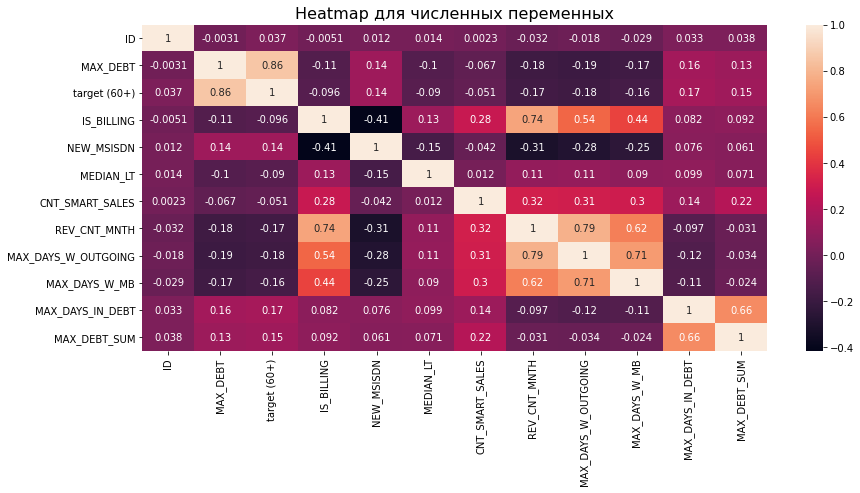

In [11]:
#построение хитмэпа
plt.figure(figsize=(14,6))
hm = sns.heatmap(df.loc[:, df.columns != 'RATINGCLASS'].corr(), annot=True)
hm.set_title('Heatmap для численных переменных',fontsize=16);

Box-pot (диаграмма размаха) дает хорошее представление о распределении величин

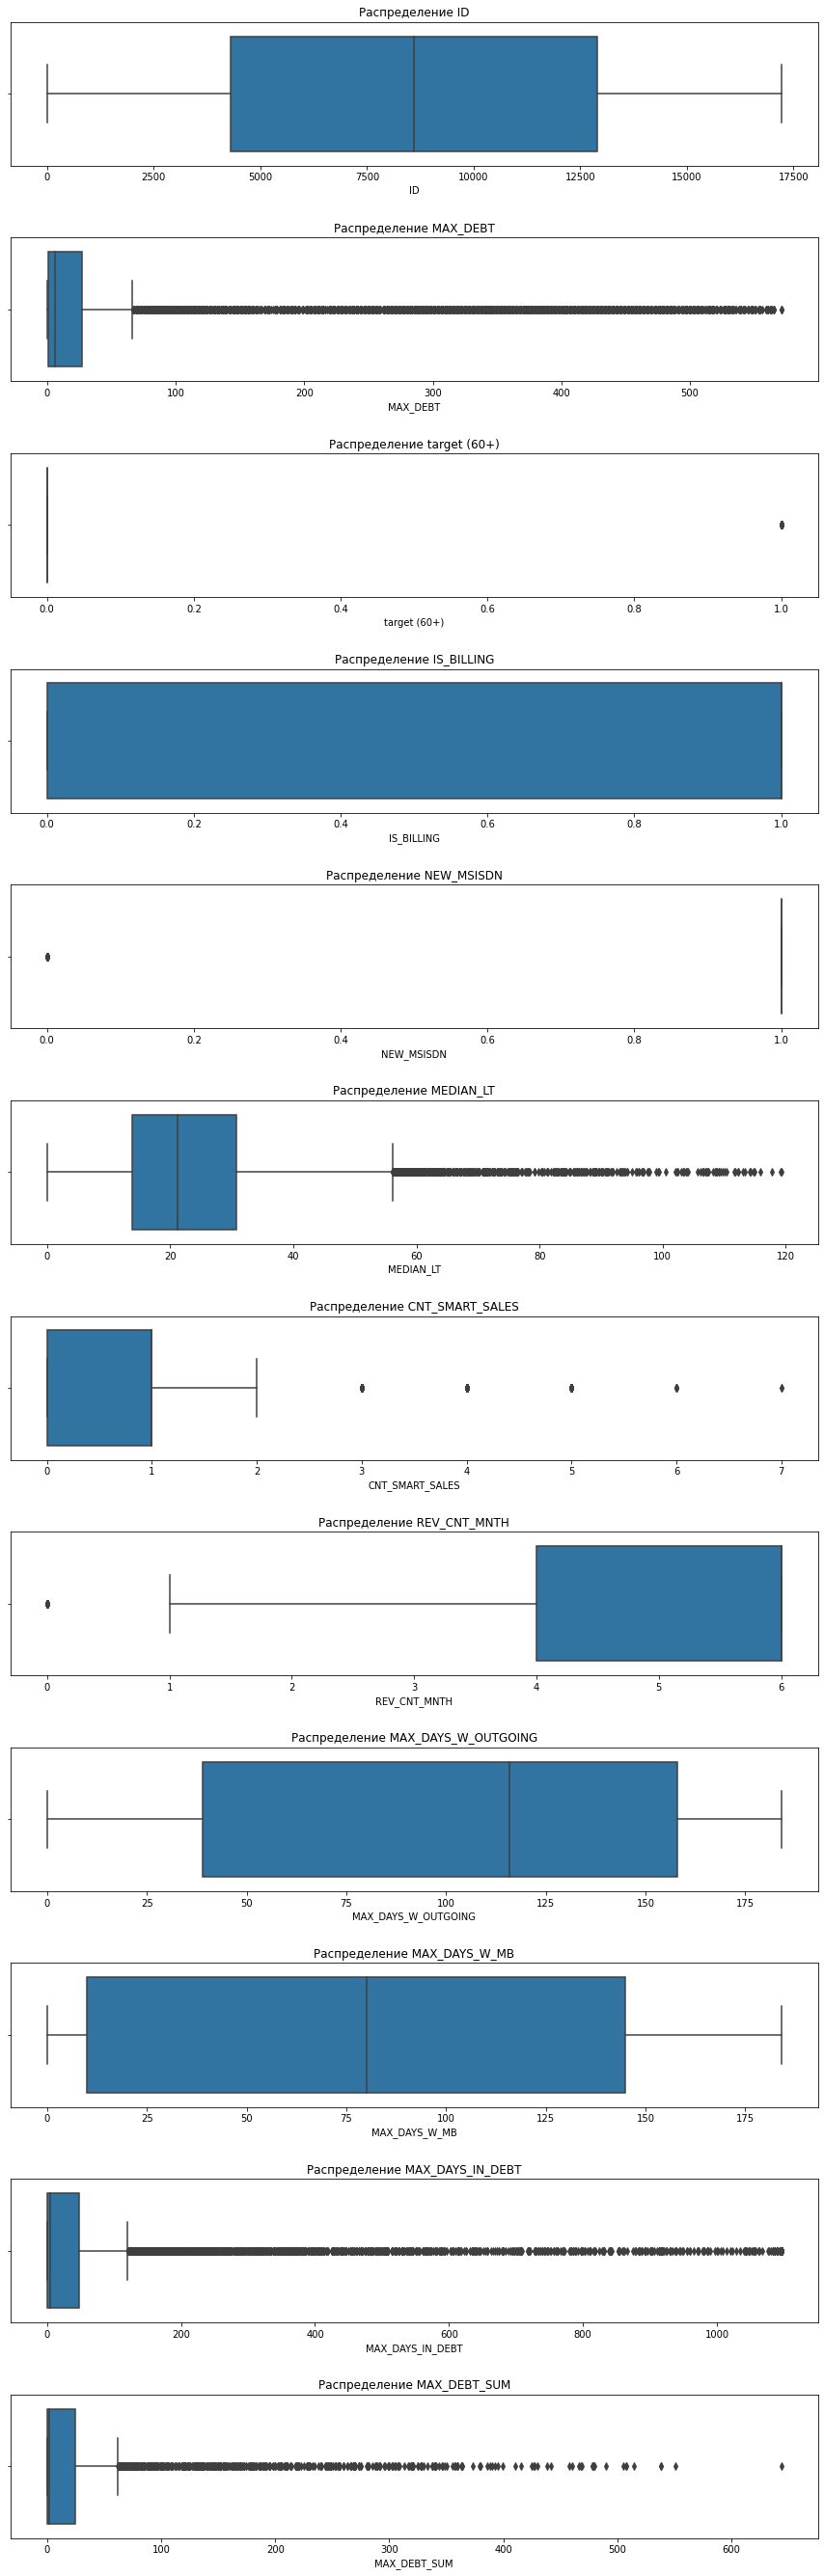

In [12]:
num_col = df.columns[df.columns != 'RATINGCLASS'] # все колонки кроме 'RATINGCLASS'

fig, ax = plt.subplots(nrows=12, ncols=1, figsize=(15, 48))
fig.subplots_adjust(hspace=.5) # расстояние между графиками

for i, col in enumerate(num_col):
    sns.boxplot(x=df[col], ax=ax[i])
    ax[i].set_title('Распределение {}'.format(col))

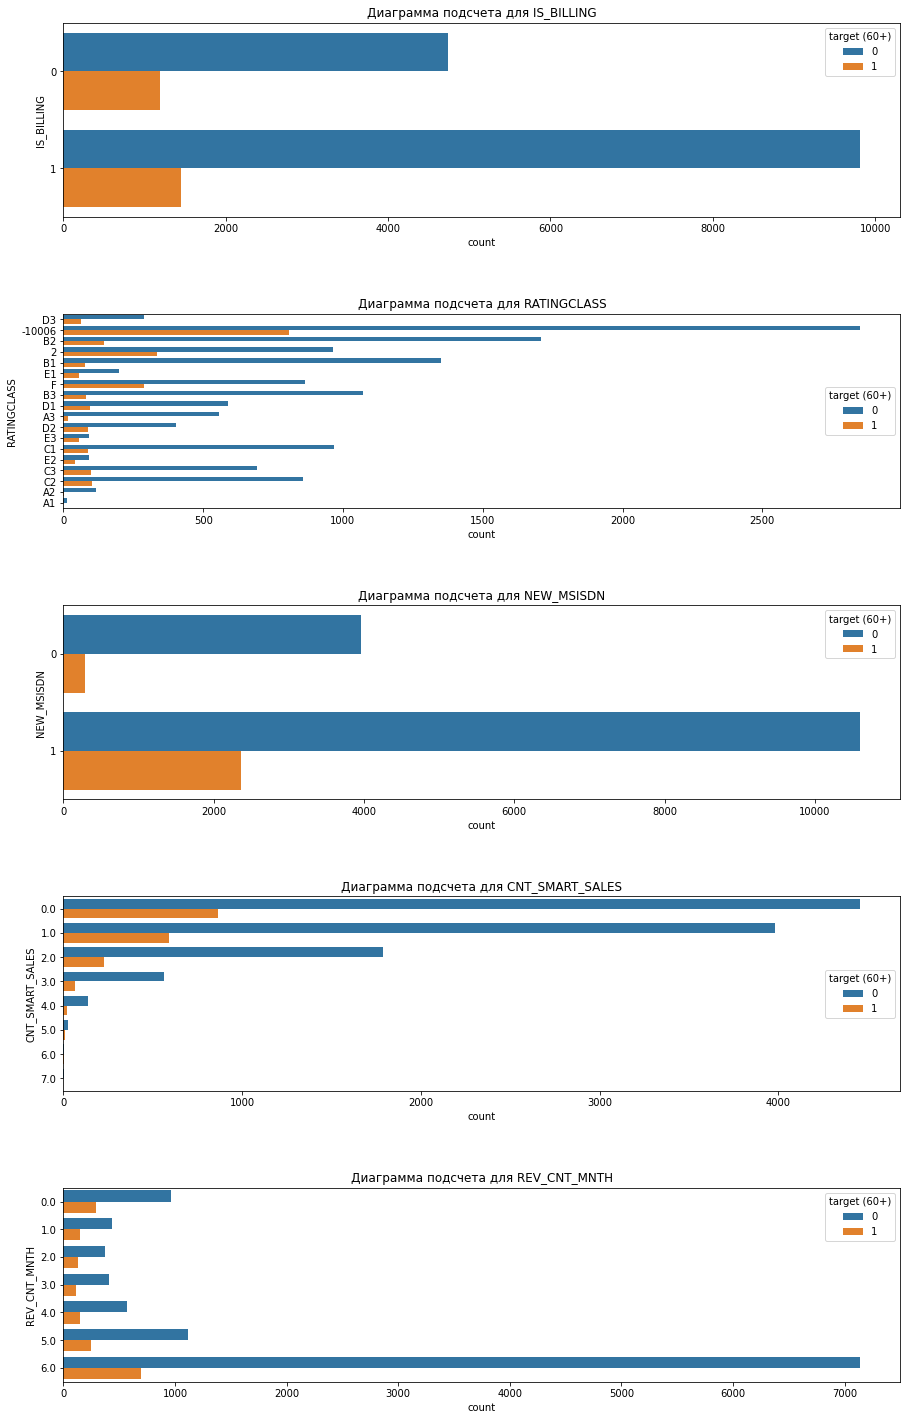

In [13]:
col1 = ['IS_BILLING', 'RATINGCLASS', 'NEW_MSISDN', 'CNT_SMART_SALES', 'REV_CNT_MNTH']

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))
fig.subplots_adjust(hspace=.5)
plt.title('Диаграммы подсчета', fontsize=16)

for i, col in enumerate(col1):
    sns.countplot(y=col, data=df, hue = 'target (60+)', ax = ax[i])
    ax[i].set_title('Диаграмма подсчета для {}'.format(col))

В колонке `RATINGCLASS` недостающие даныне заменим на *unknown*, в остальных колонках недостающие данные заменим медианным значением на основании вышеуказанных распределений

In [14]:
df['RATINGCLASS'] = df['RATINGCLASS'].fillna('unknown')

for i in df.columns[df.columns != 'RATINGCLASS']:
    df[i] = df[i].fillna(df[i].median())

Так как некотоыре переменные сильно корелируют между собой, то для дальнейшего анализа их использовать не будем. Переменные `IS_BILLING` , `MAX_DAYS_W_OUTGOING` удалим. Переменную `MAX_DEBT` так же пока отложим, `ID` так же не понадобится

In [15]:
df_new = df.drop(['ID', 'IS_BILLING' , 'MAX_DAYS_W_OUTGOING', 'MAX_DEBT'], axis=1)

In [16]:
y = df_new['target (60+)']
X = df_new.drop('target (60+)', axis=1)

In [17]:
X = pd.get_dummies(X, columns = ['RATINGCLASS'])
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

Попробуем несколько моделей для предсказаний вероятности выхода абонента в долг. Часто бывает, что нет тестового набора данных для оценки точности модели. В этом случае разобьем наши обучающие данные на подмножества обучающих и тестовых данных и вычисляем точность тестовых данных для нескольких подмножеств. Затем возьмем среднее значение вычисленной точности тестовых данных. Эта методика часто используется для приблизительного определения точности тестовых данных. В качестве метрики выберем precision (точность). Точность можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными. Датасет является сильно несбалансированным (клиентов, которые ушли в долг, значительно меньше), точность в данном случае является допустимой метрикой.

In [19]:
skf = StratifiedKFold(n_splits=5)

results = pd.DataFrame(columns=['Классификатор', 'Точность на тренировочной выборке', 
                                'Точность на тестовой выборке','Точность на кросс-валидации'])
def clf_fit_score(clf, clf_name, res=results):
    clf.fit(X_train, y_train)
    train_score, test_score, cv_score = round(precision_score(y_train, clf.predict(X_train)), 4)*100, \
                                        round(precision_score(y_test, clf.predict(X_test)),4)*100, \
                                        round(cross_val_score(clf, X_train, y_train, scoring='precision', cv=skf).mean(), 4)*100
    print('Классификатор : {}'.format(clf_name))
    print('Точность на тренировочной выборке: {}%'.format(train_score))
    print('Точность на тестовой выборке: {}%'.format(test_score))
    print('Точность на кросс-валидации: {}%'.format(cv_score))
    results.loc[len(results)] = [clf_name, train_score, test_score, cv_score]

In [20]:
lr = LogisticRegression(solver='liblinear')
clf_fit_score(lr, 'Logistic Regression')

Классификатор : Logistic Regression
Точность на тренировочной выборке: 52.17%
Точность на тестовой выборке: 46.339999999999996%
Точность на кросс-валидации: 47.339999999999996%


In [21]:
dt = DecisionTreeClassifier()
clf_fit_score(dt, 'Decision Tree Classifier')

Классификатор : Decision Tree Classifier
Точность на тренировочной выборке: 100.0%
Точность на тестовой выборке: 24.169999999999998%
Точность на кросс-валидации: 22.81%


In [22]:
rf = RandomForestClassifier(random_state=SEED)
clf_fit_score(dt, 'Random Forest Classifier')

Классификатор : Random Forest Classifier
Точность на тренировочной выборке: 100.0%
Точность на тестовой выборке: 22.759999999999998%
Точность на кросс-валидации: 22.11%


In [23]:
svc = LinearSVC(random_state=SEED)
clf_fit_score(svc, 'LinearSVC Classifier')

Классификатор : LinearSVC Classifier
Точность на тренировочной выборке: 52.83%
Точность на тестовой выборке: 57.14%
Точность на кросс-валидации: 52.61%


Для того, чтобы улучшить качество модели применим поиск оптимальных гиперпараметров

In [35]:
grid_res = []
def grid_search(clf, clf_name, params):
    search = GridSearchCV(clf, params, scoring='precision', cv=skf, n_jobs=-1)
    search.fit(X_train, y_train)
    grid_res.append(round(search.best_score_, 4) * 100)
    print("Лучшие параметры", search.best_params_)
    print("Лучшая точность {} %" .format(round(search.best_score_, 4) * 100))

In [36]:
lr_param = {'C' : np.logspace(-2, 2, 10),
           'penalty' : ['l1', 'l2']}
grid_search(lr, 'Logistic Regression', lr_param)

Лучшие параметры {'C': 0.5994842503189409, 'penalty': 'l1'}
Лучшая точность 48.35 %


In [37]:
dt_param = {'max_depth':[4, 6, 8], 'min_samples_leaf':[10, 15, 20, 30, 40]}
grid_search(dt, 'Decision Tree Classifier', dt_param)

Лучшие параметры {'max_depth': 8, 'min_samples_leaf': 20}
Лучшая точность 41.510000000000005 %


In [38]:
rf_param = {'max_depth':[10, 15, 20], 'min_samples_leaf':[5, 10, 15], 'n_estimators': [300]}
grid_search(rf, 'Random Forest Classifier', rf_param)

Лучшие параметры {'max_depth': 15, 'min_samples_leaf': 10, 'n_estimators': 300}
Лучшая точность 55.00000000000001 %


In [39]:
lvc_param = {'penalty' : ['l1', 'l2'], 'C' : np.logspace(-2, 2, 10)}
grid_search(svc, 'LinearSVC Classifier', lvc_param)

Лучшие параметры {'C': 12.915496650148826, 'penalty': 'l2'}
Лучшая точность 53.059999999999995 %


In [40]:
results['Точность после подбора параметров'] = grid_res
results

,Классификатор,Точность на тренировочной выборке,Точность на тестовой выборке,Точность на кросс-валидации,Точность после подбора параметров
0,Logistic Regression,52.17,46.34,47.34,48.35
1,Decision Tree Classifier,100.00,24.17,22.81,41.51
2,Random Forest Classifier,100.00,22.76,22.11,55.00
3,LinearSVC Classifier,52.83,57.14,52.61,53.06


Приведенные в таблице данные показывают, что первоначально лучшие результаты показывают модели логистической регрессии и метод опорных векторов. Модели решающих деревьев и случайного леса переобучены. После подбора гиперпараметров лучшие результаты показывает модель случайного леса. LinearSVC Classifier показывает немного худшие результаты, однако эта модель не возвращает вероятность, только предсказанную метку. Для дальнейшего использования рекомендуется модель Random Forest с настроенными гиперпараметрами. Так же можно посмотреть в  сторону градиентного бустинга и подбора параметров для него.

Так же попробуем изменить период, после которого клиент считается должником. Будем использовать логистическую регрессию для предварительной оценки, так метод хорошо и быстро работает без настройки параметров и хорошо интерпретируем. 

In [30]:
def optimize_period(periods, clf):
    results_date = pd.DataFrame(columns=['Количество дней в долге', 'Точность на тренировочной выборке', 
                                'Точность на тестовой выборке','Точность на кросс-валидации'])
    
    for period in periods:
        y_new = np.where(df['MAX_DEBT'] >= period, 1, 0)
        X_train, X_test, y_train, y_test = train_test_split(X, y_new, random_state=SEED)
        clf.fit(X_train, y_train)
        train_score, test_score, cv_score = round(precision_score(y_train, clf.predict(X_train)), 4)*100, \
                                        round(precision_score(y_test, clf.predict(X_test)),4)*100, \
                                        round(cross_val_score(clf, X_train, y_train, scoring='precision', cv=skf).mean(), 4)*100
        results_date.loc[len(results_date)] = [period, train_score, test_score, cv_score]
        
    plt.figure(figsize=(14,6))
    l1 = sns.lineplot(data=results_date, x="Количество дней в долге", y="Точность на кросс-валидации", 
                      color='orange', linewidth=2, marker='o')
    l1.set_title('Точность на кросс-валидации в зависимости от продолжительности задолженности',fontsize=16);  
    for x, y in zip(results_date['Количество дней в долге'], results_date['Точность на кросс-валидации']):
        l1.text(x, y, f'{y:.2f}',color='blue')
    l1.set_ylabel("Точность на кросс-валидации, %");

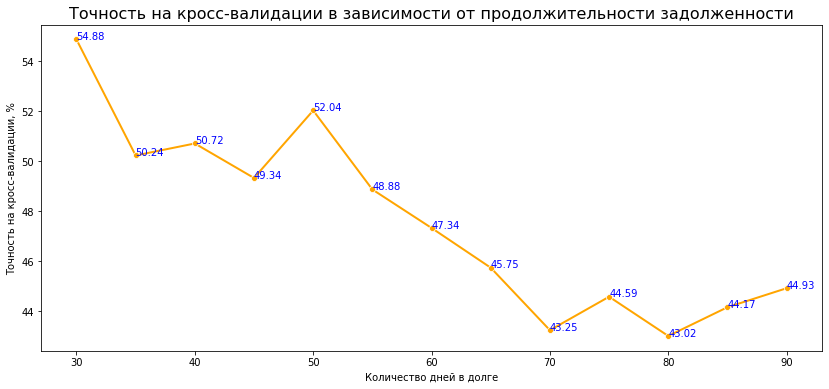

In [31]:
optimize_period([i for i in range(30, 95, 5)], clf=lr)

На принятие решение о том, после какого периода задолженности клиент становится "должником" влияет много факторов. Исходя из результатов показанных выше, можно как минимум задуматься о том, чтобы изменить этот период, например, с 60 на 50.